#  Plant Disease Detection


Mounted at /content/drive
Found 737 images belonging to 15 classes.
Found 183 images belonging to 15 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 327s 13s/step - accuracy: 0.7797 - loss: 0.7122 - val_accuracy: 0.9836 - val_loss: 0.0333
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9889 - loss: 0.0442 - val_accuracy: 0.9836 - val_loss: 0.0470
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.9879 - loss: 0.0251 - val_accuracy: 0.9945 - val_loss: 0.0125
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.9969 - loss: 0.0079 - val_accuracy: 0.9891 - val_loss: 0.0239
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9865 - loss: 0.0306 - val_accuracy: 0.9945 - val_loss: 0.0201
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.9926 - loss: 0.0190 - val_accuracy: 1.0000 - val_loss: 0.0115
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.9987 - loss: 0.0102 - val_accuracy: 1.0000 - val_loss: 0.0062
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.9984 - loss: 0.0080 - val_accuracy: 0.9891 - val_los

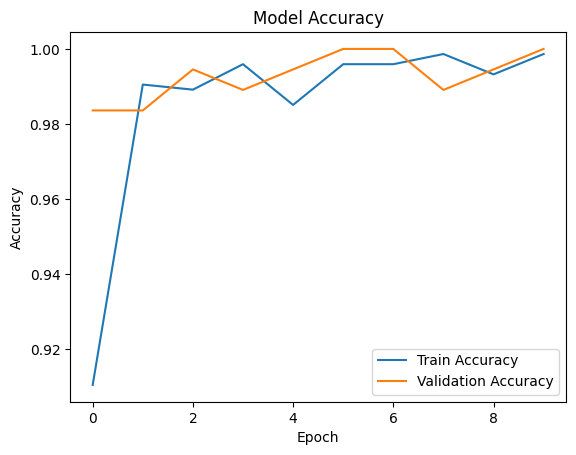

In [1]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

#Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os
import json

#Define dataset path (update if needed)
dataset_path = '/content/drive/MyDrive/PlantVillage'

#Image data generator with augmentation
img_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

#Save class indices to reuse during prediction
label_map = train_generator.class_indices
inv_label_map = {v: k for k, v in label_map.items()}
with open('/content/drive/MyDrive/plant_labels.json', 'w') as f:
    json.dump(inv_label_map, f)

#Load base model and add custom classifier
base_model = MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Train the model
epochs = 10
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

#Save the trained model
model.save('/content/drive/MyDrive/plant-disease-transfer.keras')
print("Model saved to Drive!")

#Plot training accuracy and loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [2]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# STEP 2: Import libraries
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from PIL import Image, ImageOps
import numpy as np
import json
from google.colab import files

# STEP 3: Load the trained model and labels
model = tf.keras.models.load_model('/content/drive/MyDrive/plant-disease-transfer.keras')

with open('/content/drive/MyDrive/plant_labels.json', 'r') as f:
    class_labels = json.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Text(0.5, 1.0, ' Test Image: Potato Healthy')

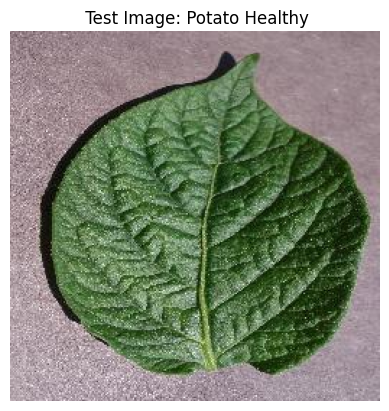

In [3]:
plt.imshow(Image.open('/content/drive/MyDrive/PlantVillage/Potato___healthy/00fc2ee5-729f-4757-8aeb-65c3355874f2___RS_HL 1864.JPG')); plt.axis('off'); plt.title(' Test Image: Potato Healthy')



In [4]:

image_path = '/content/drive/MyDrive/PlantVillage/Potato___healthy/00fc2ee5-729f-4757-8aeb-65c3355874f2___RS_HL 1864.JPG'  # 👈 your image path here

print(f" Loading image: {image_path}")


img = Image.open(image_path).convert("RGB")
img = ImageOps.fit(img, (224, 224), Image.Resampling.LANCZOS)
img_array = np.asarray(img).astype(np.float32)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Prediction
prediction = model.predict(img_array)
predicted_index = np.argmax(prediction[0])
confidence = prediction[0][predicted_index] * 100
label = class_labels[str(predicted_index)]

# Output
print(f" Predicted Plant Condition: {label}")
print(f" Confidence: {confidence:.2f}%")


 Loading image: /content/drive/MyDrive/PlantVillage/Potato___healthy/00fc2ee5-729f-4757-8aeb-65c3355874f2___RS_HL 1864.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
 Predicted Plant Condition: Potato___healthy
 Confidence: 99.99%
